In [82]:
#!/usr/bin/env python
# coding: utf-8
from time import gmtime, strftime

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from PIL import Image
import shutil
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# ---- My utils ----
import sys
sys.path.insert( 0, '../..' ) # To be able to access to utils
from models import *
from utils.train_arguments import *
from utils.utils_data import *
from utils.utils_training import *

### Load data

In [5]:
args.img_size = 256
args.crop_size = 224
args.pretrained = True
args.batch_size = 128
args.validation_size = 0.15
args.get_path = True

In [6]:
if args.data_augmentation:
    train_aug = [
        transforms.ToPILImage(),  # because the input dtype is numpy.ndarray
        transforms.Resize((args.img_size, args.img_size)),
        transforms.RandomCrop((args.crop_size, args.crop_size)),
        transforms.RandomHorizontalFlip(0.5),  # because this method is used for PIL Image dtype
        transforms.RandomVerticalFlip(0.5),  # because this method is used for PIL Image dtype
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        transforms.ToTensor(),  # because inpus dtype is PIL Image
    ]
else:
    train_aug = [
        transforms.ToPILImage(),  # because the input dtype is numpy.ndarray
        transforms.Resize((args.img_size, args.img_size)),
        transforms.CenterCrop((args.crop_size, args.crop_size)),
        transforms.ToTensor(),  # because inpus dtype is PIL Image
    ]

val_aug = [
    transforms.ToPILImage(),  # because the input dtype is numpy.ndarray
    transforms.Resize((args.img_size, args.img_size)),
    transforms.CenterCrop((args.crop_size, args.crop_size)),
    transforms.ToTensor(),  # because inpus dtype is PIL Image
]

if args.pretrained:
    train_aug.append(transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
    val_aug.append(transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))

# data_partition='', data_augmentation=None, validation_size=0.15, seed=42
train_dataset = SIMEPU_Dataset(data_partition='train', transform=transforms.Compose(train_aug), validation_size=args.validation_size)
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, pin_memory=True, shuffle=True)

val_dataset = SIMEPU_Dataset(data_partition='validation', transform=transforms.Compose(val_aug), validation_size=args.validation_size)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, pin_memory=True, shuffle=False)

### Load model

In [7]:
args.model_name = "resnet18"
model_checkpoint = "model_best_accuracy.pt"

In [8]:
model = model_selector(args.model_name, num_classes=len(LABELS2TARGETS), pretrained=args.pretrained)
model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
model.load_state_dict(torch.load(model_checkpoint))
model = model.eval()

Pretrained-> Remember at end: transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm

#### Validation error

In [9]:
args.weighted_loss = True

In [10]:
if args.weighted_loss:
    print("Loaded Class weights!")
    with open("../../utils/class_weights_divide.pkl", "rb") as fp:  # Unpickling
        weights = pickle.load(fp)
    print("Weights: {}".format(weights))
    class_weights = torch.FloatTensor(weights).cuda()
    criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights, device='cuda'))
else:
    criterion = nn.CrossEntropyLoss()

Loaded Class weights!
Weights: [6.626878130217029, 6.4439935064935066, 3.1023837436498636, 43.14673913043478, 20.567357512953368, 16.006048387096776, 6.632414369256474, 21.284182305630026, 25.28343949044586]


In [11]:
current_val_loss, current_val_accuracy = val_step(val_loader, model, criterion)

In [12]:
print("-----------------------------")
print("Validation Accuracy {:.4f}%".format(current_val_accuracy))
print("-----------------------------")

-----------------------------
Validation Accuracy 93.0690%
-----------------------------


### Getting confidences

In [57]:
model.eval()
val_loss, correct, confidence, total = 0, np.array([]), np.array([]), 0
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(val_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = model(inputs)
        
        _, predicted = outputs.max(1)
        total += targets.size(0)
        confidence = np.append(confidence, torch.topk(F.softmax(outputs, dim=1), 1)[0].squeeze().data.cpu().numpy())
        correct = np.append(correct, (predicted.eq(targets)*1).data.cpu().numpy())
    
    val_accuracy = 100. * correct.sum() / total

In [54]:
val_accuracy

93.06901177522731

In [77]:
correct_confidence = confidence[np.where(correct == 1)[0]]
incorrect_confidence = confidence[np.where(correct == 0)[0]]

In [79]:
100 * len(correct_confidence) / (len(correct_confidence)+len(incorrect_confidence))

93.06901177522731

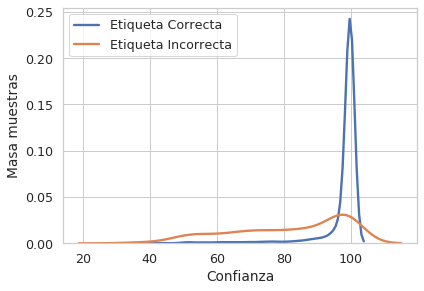

In [135]:
#sns.set_style("dark")
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.15, rc={"lines.linewidth": 2.35})
plt.yticks(np.arange(0, 0.3, 0.05))
plt.tight_layout()

plt.ylabel("Masa muestras")
plt.xlabel("Confianza")

sns.distplot(correct_confidence*100, hist=False, rug=False, label="Etiqueta Correcta")
sns.distplot(incorrect_confidence*100, hist=False, rug=False, label="Etiqueta Incorrecta")
plt.legend(fancybox=True)
plt.savefig('confidence_analysis.png', transparent=True, dpi=800)